# **Installations**

In [1]:
!pip install geodatasets
!pip install geoplot
!pip install pylibtiff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pylibtiff: filename=pylibtiff-0.6.1-cp310-cp310-linux_x86_64.whl size=202904 sha256=c2d21cd43439b2ee18da1d4de33063a38cc561bc0f855f754072de9dd7c477cf
  Stored in directory: /root/.cache/pip/wheels/18/3a/a4/2fecac4e3bf7f84b3cac4d79f138869401b18dde7a3f07e591
Successfully built pylibtiff


# **Imports**

In [2]:
import geopandas as gpd
import geodatasets
import geoplot
import geoplot.crs as gcrs
import pandas as pd
import numpy as np
from osgeo import ogr, osr, gdal
import rasterio
from google.colab import drive
from libtiff import TIFF
from sklearn import tree
from rasterio.plot import show
from rasterio.windows import Window
from shapely.geometry import Point, LineString, Polygon
import rasterio.mask
import itertools
import mapclassify as mc
import numba
from sklearn import svm
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing as pre
import warnings
import os
import numpy as np
warnings.filterwarnings("ignore")
drive.mount('/content/drive', force_remount=True)
local = '/content/drive/MyDrive/Generalization method for recommendation system native species for the practice of melliponiculture'

Mounted at /content/drive


# **Read csv and clean data**

In [3]:
# GBIF.org (13 November 2023) GBIF Occurrence Download  https://doi.org/10.15468/dl.xxkuhm
meliponas = pd.read_csv(local + '/Meliponini.csv' , engine='python')

In [4]:
meliponas = meliponas[((meliponas['species'] == 'Lestrimelitta limão') |
    (meliponas['species'] == 'Partamona helleri') |
    (meliponas['species'] == 'Tetragona clavipes') |
    (meliponas['species'] == 'Melipona bicolor') |
    (meliponas['species'] == 'Trigona spinipes') |
    (meliponas['species'] == 'Tetragonisca angustula') |
    (meliponas['species'] == 'Leurotrigona muelleri') |
    (meliponas['species'] == 'Melipona mandacaia') |
    (meliponas['species'] == 'Melipona marginata') |
    (meliponas['species'] == 'Frieseomelitta varia') |
    (meliponas['species'] == 'Cephalotrigona capitata') |
    (meliponas['species'] == 'Scaptotrigona bipunctata') |
    (meliponas['species'] == 'Melipona scutellaris')) &
    ((meliponas['decimalLatitude'].notnull()) &
     (meliponas['decimalLongitude'].notnull()))
]

# **Create GeoDataframe**



In [5]:
gdf_meliponas = gpd.GeoDataFrame(
    meliponas, geometry=gpd.points_from_xy(meliponas.decimalLongitude, meliponas.decimalLatitude), crs="EPSG:4326"
)

# **Read SHP file**

In [6]:
brazil = gpd.read_file(local + '/BR_UF_2022/BR_UF_2022.shp')

# **KDE Plot**

<Axes: >

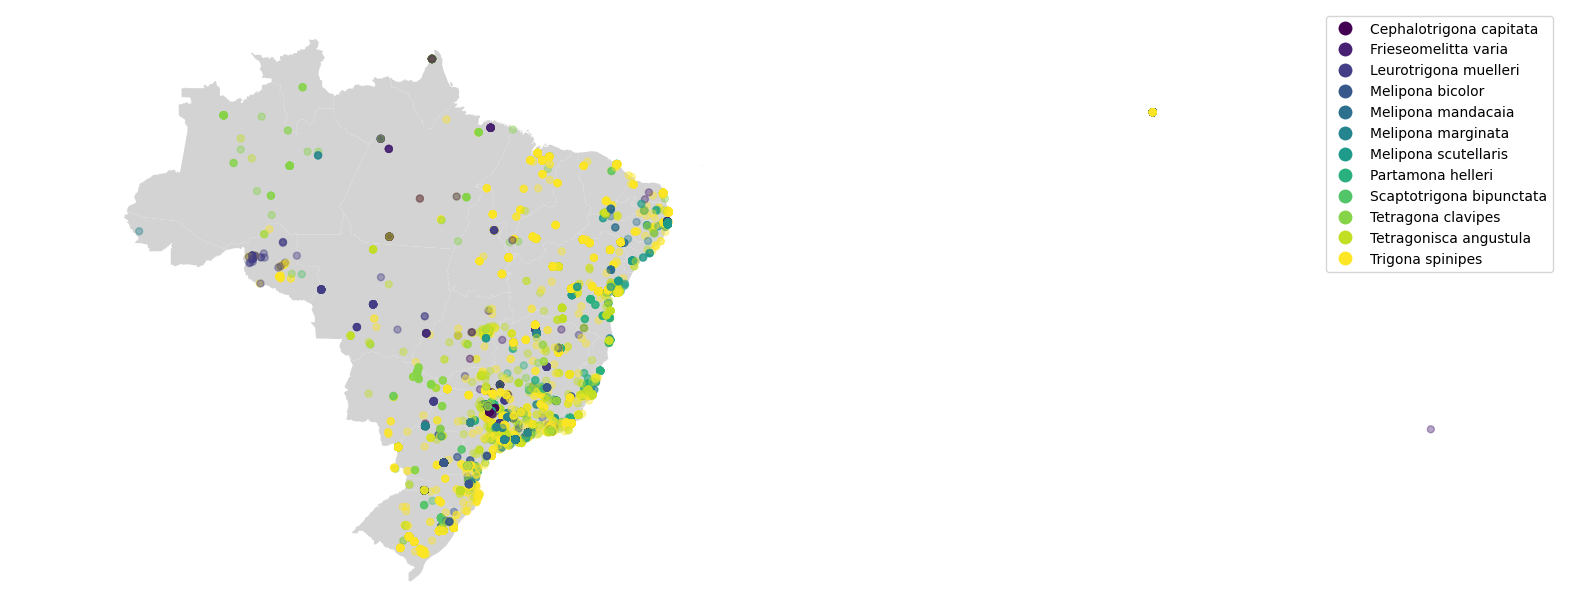

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
brazil.plot(color='lightgrey', ax=ax)
# divider = make_axes_locatable(ax)
geoplot.pointplot(gdf_meliponas, ax=ax, limits=(3, 50), zorder=2,
     alpha = 0.4, hue='species', cmap='viridis',
     legend=True, legend_var='hue')

<Axes: >

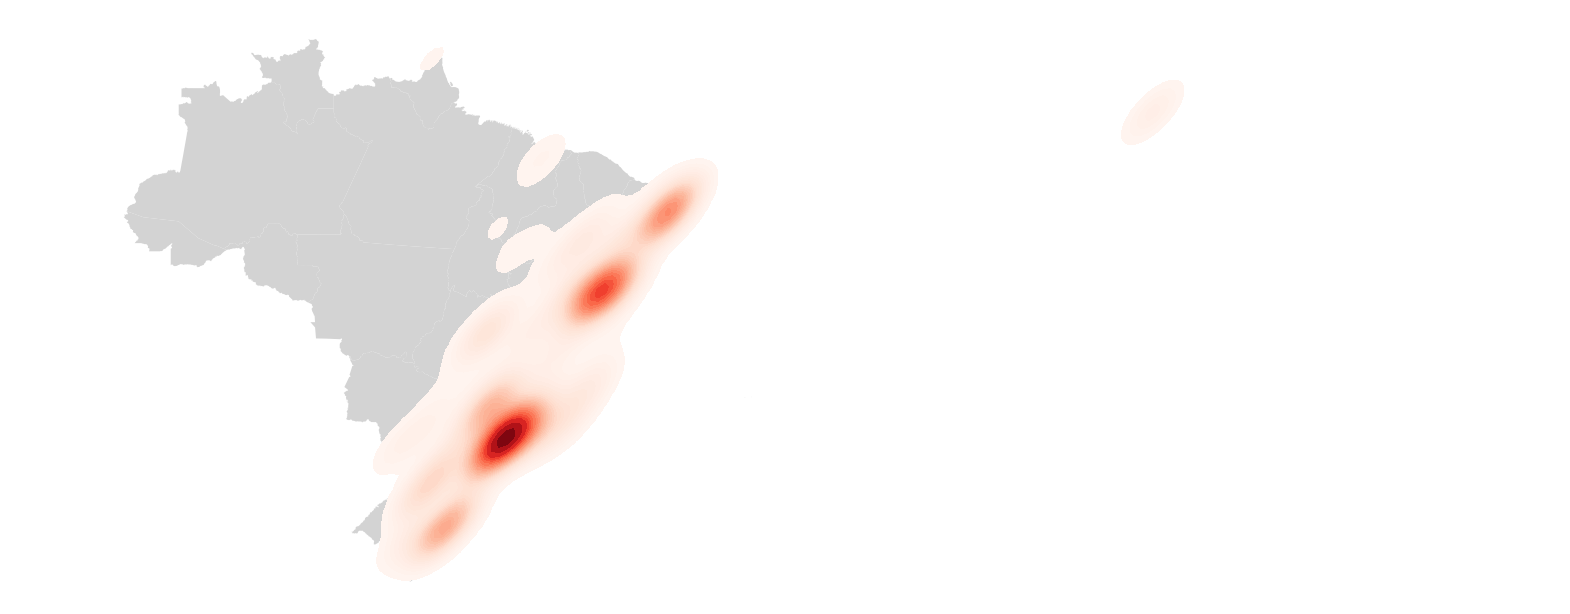

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
brazil.plot(color='lightgrey', ax=ax)
geoplot.kdeplot(gdf_meliponas, n_levels=30, cmap='Reds', ax=ax, fill=True)


In [9]:
X = meliponas[['decimalLatitude',	'decimalLongitude']].to_numpy()

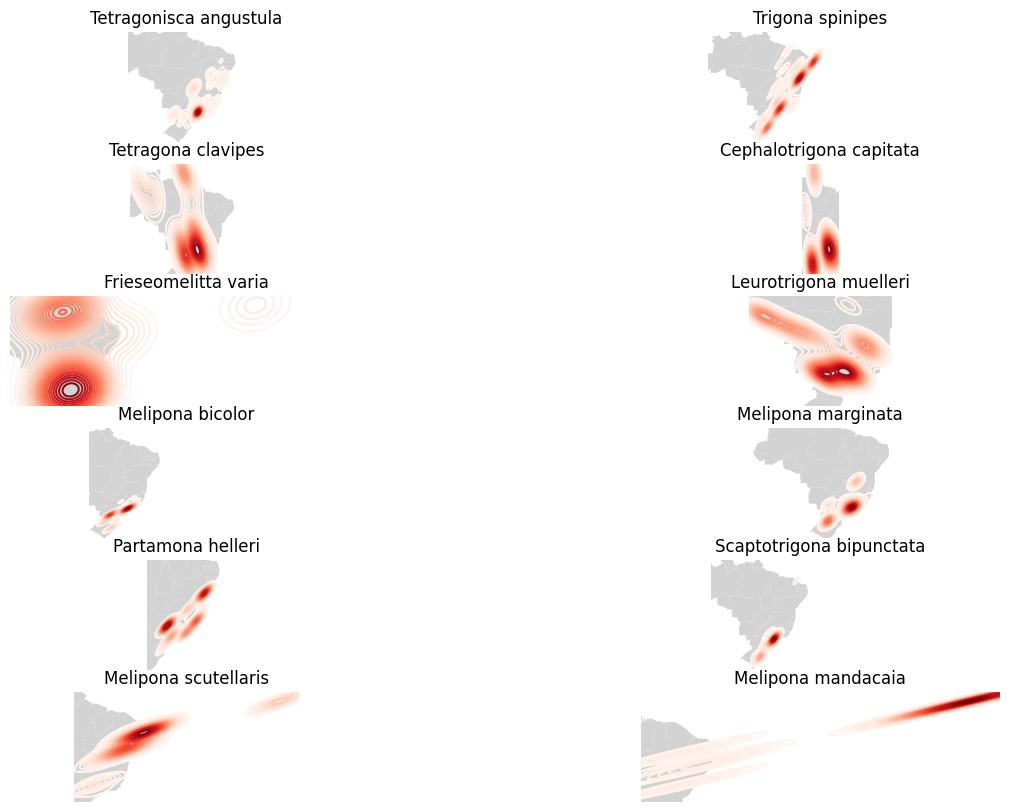

<Axes: title={'center': 'Melipona mandacaia'}>

In [10]:
position = 1
species = gdf_meliponas['species'].unique()
fig = plt.figure(1, figsize=(15,10))
for index, specie in enumerate(species):
  ax = fig.add_subplot(int(len(species)/2), 2, position)
  brazil.plot(color='lightgrey', ax=ax)
  position+=1
  geoplot.kdeplot(gdf_meliponas[gdf_meliponas['species'] == specie], n_levels=30, cmap='Reds', ax=ax)
  plt.title(specie)
plt.show()

ax

In [11]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.2, metric="haversine").fit(X)
kde_wo_normalize =  kde.score_samples(X)

kde_wo_normalize = kde_wo_normalize.reshape(-1,1)
gdf_meliponas['KDE'] = pre.MinMaxScaler().fit_transform(kde_wo_normalize)

# **Get NDVI**

In [12]:
@numba.jit
def getImageValue(imageRaster, lat,lon):
  band1 = imageRaster.read(1)
  row, col = imageRaster.index(lon, lat, precision=1E-6)
  return band1[row, col]

# **Create empty dataframe with all Coordinates**



In [13]:
brazilianLat = np.arange(-33.7507206, 5.2691609, 0.01, dtype=float)

brazilianLon = np.arange(-73.9853856, -28.8837885, 0.01, dtype=float)

all_coordinates = list(itertools.product(brazilianLat,brazilianLon))

brazil_df = pd.DataFrame(list(all_coordinates), columns=["Latitude", "Longitude"])

# **Add NEO Indexes to all coordinates**



In [14]:
ndviRaster = rasterio.open(local + '/TIFF Files/NDVI.TIFF')
brazil_df['NDVI'] = getImageValue(ndviRaster, brazil_df['Latitude'].to_numpy(), brazil_df['Longitude'].to_numpy())


landCoberRaster = rasterio.open(local + '/TIFF Files/LandCover.TIFF')
brazil_df['LandCover'] = getImageValue(landCoberRaster, brazil_df['Latitude'].to_numpy(), brazil_df['Longitude'].to_numpy())


topographyRaster = rasterio.open(local + '/TIFF Files/Topography.TIFF')
brazil_df['Topography'] = getImageValue(topographyRaster, brazil_df['Latitude'].to_numpy(), brazil_df['Longitude'].to_numpy())


In [15]:
brazil_df['NDVI'] = np.where(brazil_df['NDVI']== 99999.0, -1.0, brazil_df['NDVI'])
brazil_df['Topography'] = np.where(brazil_df['Topography']== 99999.0, 0, brazil_df['Topography'])


# **Add NEO Indexes to Bees Dataframe**





In [16]:
ndviRaster = rasterio.open(local + '/TIFF Files/NDVI.TIFF')
gdf_meliponas['NDVI'] = getImageValue(ndviRaster, gdf_meliponas['decimalLatitude'].to_numpy(), gdf_meliponas['decimalLongitude'].to_numpy())


landCoberRaster = rasterio.open(local + '/TIFF Files/LandCover.TIFF')
gdf_meliponas['LandCover'] = getImageValue(landCoberRaster, gdf_meliponas['decimalLatitude'].to_numpy(), gdf_meliponas['decimalLongitude'].to_numpy())


topographyRaster = rasterio.open(local + '/TIFF Files/Topography.TIFF')
gdf_meliponas['Topography'] = getImageValue(topographyRaster, gdf_meliponas['decimalLatitude'].to_numpy(), gdf_meliponas['decimalLongitude'].to_numpy())


In [17]:
gdf_meliponas['NDVI'] = np.where(gdf_meliponas['NDVI']== 99999.0, -1.0, gdf_meliponas['NDVI'])
gdf_meliponas['Topography'] = np.where(gdf_meliponas['Topography']== 99999.0, 0, gdf_meliponas['Topography'])

In [18]:
@numba.jit
def beesExists(lat, lon):
  teste = gdf_meliponas[np.isclose(lat, gdf_meliponas['decimalLatitude'].to_numpy(), atol=0.0999) & np.isclose(lon, gdf_meliponas['decimalLongitude'].to_numpy(), atol=0.0999)]['KDE'][:1].values
  if(len(teste) > 0 ):
    return teste[0]
  else:
    return 0

# **Create Models**

In [19]:
# df_train['KDE'] = [beesExists(row['Latitude'], row['Longitude']) for index, row in df_train.iterrows()]

In [20]:
brazil_gdf = gpd.GeoDataFrame(
    brazil_df, geometry=gpd.points_from_xy(brazil_df.Longitude, brazil_df.Latitude), crs="EPSG:4326"
)

In [21]:
species = list(gdf_meliponas.groupby('species').count().sort_values('countryCode', ascending=False)[:3].index)


In [ ]:
withBees = np.arange(0.25, 1, 0.25)
withoutBees = np.arange(0.75, 0, -0.25)
features = ['NDVI',	'LandCover',	'Topography', ['NDVI',	'LandCover'], ['NDVI', 'Topography'], ['LandCover',	'Topography'], ['NDVI',	'LandCover',	'Topography']]
clf = DecisionTreeRegressor(random_state=5)


for specie in species:
  print(specie)
  for wb, wob in zip(withBees, withoutBees):
    sample = 1000 if len(gdf_meliponas[gdf_meliponas['species']  == specie]) > 1000 else len(gdf_meliponas[gdf_meliponas['species']  == specie])
    df_train = pd.concat([gdf_meliponas[gdf_meliponas['species']  == specie][['decimalLatitude', 'decimalLongitude', 'NDVI', 'LandCover', 'Topography']].rename(
                        columns={'decimalLatitude':'Latitude', 'decimalLongitude':'Longitude'}).sample(n = int(sample * wb)),
                        brazil_df[['Latitude', 'Longitude','NDVI', 'LandCover', 'Topography']].sample(n = int(sample * wob))],
                        ignore_index=True,).sample(frac=1).reset_index(drop=True)
    df_train['KDE'] = [beesExists(row['Latitude'], row['Longitude']) for index, row in df_train.iterrows()]
    clf = DecisionTreeRegressor(random_state=5)
    print(f'{round(wob, 2)} Without Bees X {round(wb, 2)} With Bees - Features: {features[len(features)-1]} - Specie: {specie}')
    clf.fit(df_train[features[len(features)-1]], df_train['KDE'])
    brazil_gdf['predict'] = clf.predict(brazil_gdf[features[len(features)-1]])
    fig, ax = plt.subplots(figsize = (10,10))
    brazil.plot(ax=ax, color='lightgrey')
    brazil_gdf.plot(column = 'predict', ax=ax, cmap = 'Reds',
                legend = True, legend_kwds={'shrink': 0.3},
                markersize = 10)
    ax.set_title(f'{round(wob, 2)} Without Bees X {round(wb, 2)} With Bees - Features: {features[len(features)-1]} - Specie: {specie}')
    if not os.path.exists(local + f'/Modelos/{specie}'):
        os.makedirs(local + f'/Modelos/{specie}')
    fig.savefig(local + f'/Modelos/{specie}/Features: {features[len(features)-1]} - {round(wob, 2)} Without Bees X {round(wb, 2)} With Bees.png')

Trigona spinipes
0.75 Without Bees X 0.25 With Bees - Features: ['NDVI', 'LandCover', 'Topography'] - Specie: Trigona spinipes


In [ ]:
features = ['NDVI',	'LandCover',	'Topography', ['NDVI',	'LandCover'], ['NDVI', 'Topography'], ['LandCover',	'Topography']]
clf = DecisionTreeRegressor(random_state=5)

for specie in species:
  print(specie)
  for feature in features:
    sample = 1000 if len(gdf_meliponas[gdf_meliponas['species']  == specie]) > 1000 else len(gdf_meliponas[gdf_meliponas['species']  == specie])
    df_train = pd.concat([gdf_meliponas[gdf_meliponas['species']  == specie][['decimalLatitude', 'decimalLongitude', 'NDVI', 'LandCover', 'Topography']].rename(
                        columns={'decimalLatitude':'Latitude', 'decimalLongitude':'Longitude'}).sample(n = int(sample * 0.5)),
                        brazil_df[['Latitude', 'Longitude','NDVI', 'LandCover', 'Topography']].sample(n = int(sample * 0.5))],
                        ignore_index=True,).sample(frac=1).reset_index(drop=True)
    df_train['KDE'] = [beesExists(row['Latitude'], row['Longitude']) for index, row in df_train.iterrows()]

    clf = DecisionTreeRegressor(random_state=5)
    print(f'50 Without Bees X 50 With Bees - Features: {feature} - Specie: {specie}')
    if(type(feature) == str):
      clf.fit(df_train[feature].values.reshape(-1,1), df_train['KDE'])
      brazil_gdf['predict'] = clf.predict(brazil_gdf[feature].values.reshape(-1,1))
    else:
      clf.fit(df_train[feature], df_train['KDE'])
      brazil_gdf['predict'] = clf.predict(brazil_df[feature])
    fig, ax = plt.subplots(figsize = (10,10))
    brazil.plot(ax=ax, color='lightgrey')
    brazil_gdf.plot(column = 'predict', ax=ax, cmap = 'Reds',
                legend = True, legend_kwds={'shrink': 0.3},
                markersize = 10)
    ax.set_title(f'50 Without Bees X 50 With Bees - Features: {feature} - Specie: {specie}')
    if not os.path.exists(local + f'/Modelos/{specie}'):
        os.makedirs(local + f'/Modelos/{specie}')
    fig.savefig(local + f'/Modelos/{specie}/Feature: {feature} - 50 Without Bees X 50 With Bees.png')